In [211]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f'Value(data = {self.data})'
    
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int,float)) # only support int & float powers for now
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rtruediv__(self, other):
        return self * (other ** -1)

    
    def sigmoid(self):
        x = self.data
        s = 1/(1+ math.exp(-x))
        out = Value(s, (self, ), 'sigmoid')

        def _backward():
            self.grad += s * (1-s)

        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        r = max(x,0)
        out = Value(r, (self, ), 'ReLU')

        def _backward():
            self.grad += 1 if x > 0 else 0

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def linear(self):
        x = self.data
        out = Value(x, (self, ), 'linear')

        def _backward():
            self.grad += 1
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    

    def backward(self):
        topological = []
        visited = set()

        def build_topological(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological(child)
                topological.append(v)

        build_topological(self)
        
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

In [235]:
class Neuron:
    
    def __init__(self, numIn, activation) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(numIn)]
        self.b = Value(random.uniform(-1,1))
        self.act_func = activation
    
    def __call__(self, x):
        # w . x + b
        act = sum(w1*x1 for w1, x1 in zip(self.w, x)) + self.b
        out = getattr(act, self.act_func)()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, numIn, numOut, activation) -> None:
        self.neurons = [Neuron(numIn, activation) for _ in range(numOut)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
        
class MLP:
    def __init__(self, numIn, numOuts, activations) -> None:
        sizes = [numIn] + numOuts 
        self.layers = [Layer(sizes[i], sizes[i+1], activations[i]) for i in range(len(numOuts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        

In [248]:

n = MLP(3, [4, 4, 1] , ['tanh','tanh','tanh'])


In [249]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


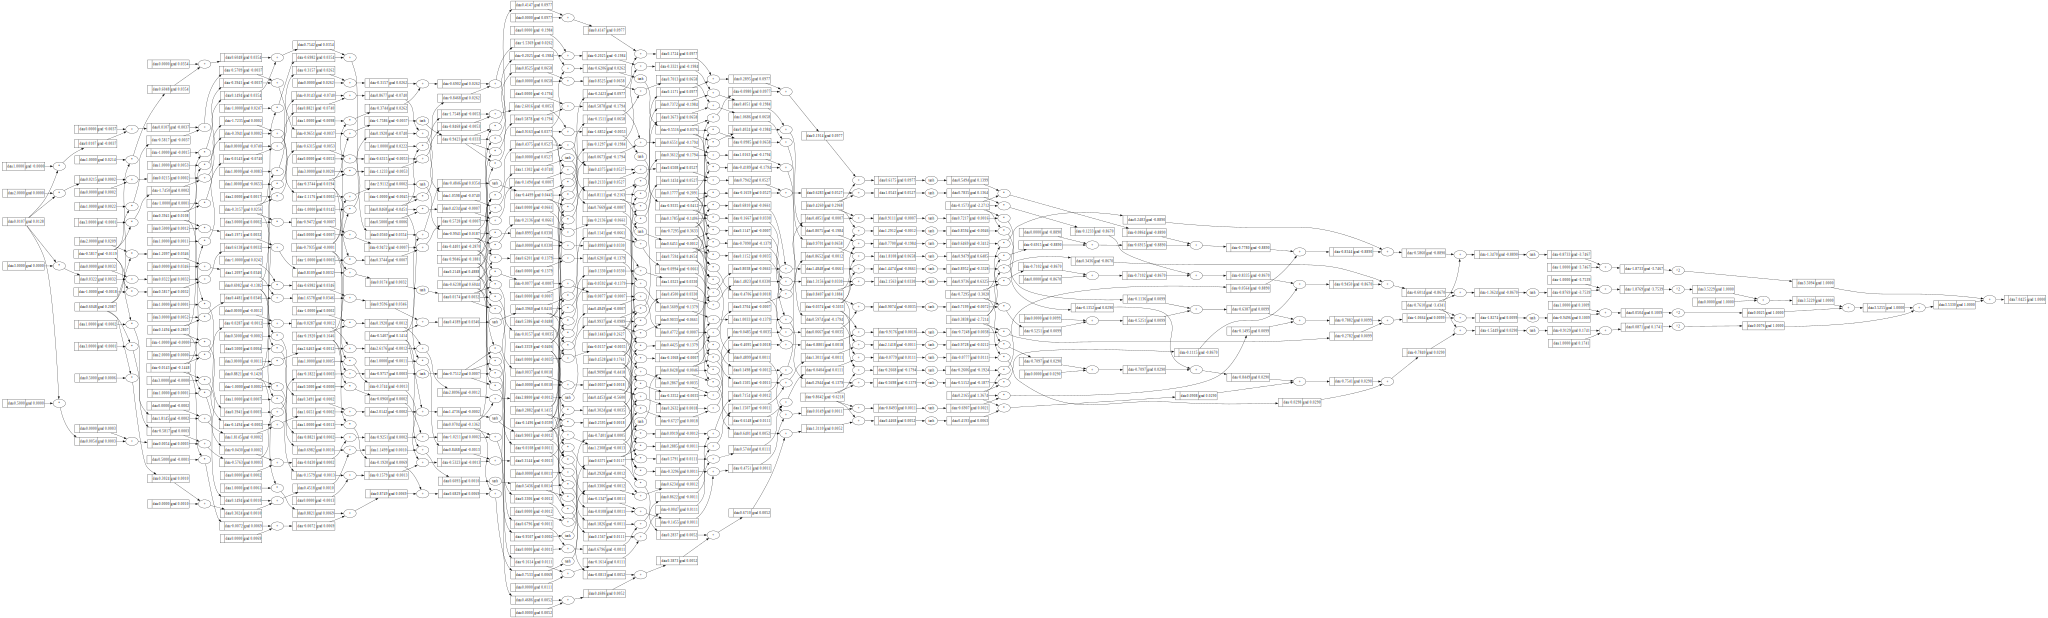

In [253]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss.backward()

draw_dot(loss)

In [247]:
for k in range(20):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print (k, loss.data)

ypred


0 0.0017035347361090611
1 0.0016941996817272595
2 0.0016849645990022818
3 0.001675827900546094
4 0.0016667880322912517
5 0.001657843472622906
6 0.0016489927315377747
7 0.001640234349829189
8 0.0016315668982970191
9 0.0016229889769819104
10 0.0016144992144227687
11 0.0016060962669367184
12 0.0015977788179207496
13 0.0015895455771743326
14 0.001581395280242203
15 0.001573326687776661
16 0.0015653385849187297
17 0.0015574297806974912
18 0.0015495991074469106
19 0.0015418454202398599


[Value(data = 0.9812310097682712),
 Value(data = -0.9862009385800045),
 Value(data = -0.9751380317900509),
 Value(data = 0.9804797831319476)]

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

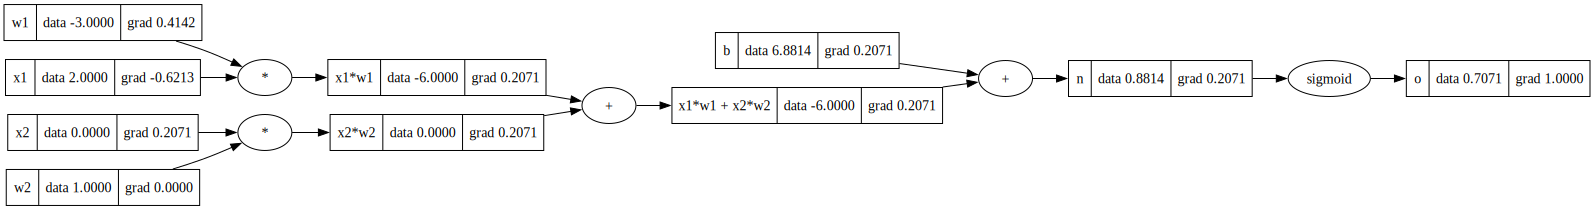

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.sigmoid(); o.label = 'o'

o.backward()
draw_dot(o)


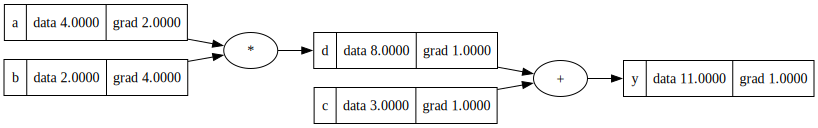

In [7]:
# y = (a * b) + c 
a = Value(4.0, label='a')
b = Value(2.0, label='b')
c = Value(3.0, label='c')

d = a * b
d.label = 'd'

y = d + c
y.label = 'y'

y.backward()
draw_dot(y)

# dy/da = b = 2
# dy/db = a = 4
# dy/dc = 1